In [40]:
##########################################
#Mini-Project for Image Processing and Computer Vision
#Faster R-CNN on the Long-Term Thermal Drift Dataset
#November 2023
#Esben Dissing Bregnballe, Sameer Aqib  Hashmi, Simon Loi Baks, Vasiliki Ismiroglou
##########################################

In [1]:
from sklearn.preprocessing import LabelEncoder
from src.dataset import FrameDataset
from torch.utils.data import DataLoader
from src.utils import collate_fn
import torch
import os
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm 

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from src.config import hparams

Initiating the model to test, the label encoder as well as the dataset and dataloaders

In [2]:
le = LabelEncoder()
le.fit(['apadding', 'bicycle','human', 'motorcycle', 'vehicle']);

In [25]:
device = torch.device('cuda')#change to cpu to work on cpu
model = torch.load('products/epoch20-best_model.pth')#Insert model path here
model.eval()
model.to(device);

In [4]:
#This only works if your relative paths to the data are exactly the same as the .txt file. Otherwise you need to find a different way to feed them in the dataset class.
file = open('test_dataset.txt', 'r')
test_data = file.read().split('\n')
del test_data[-1]

test_dataset = FrameDataset('', le)
test_dataset.img_files = test_data

In [5]:
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

Calculating Mean Average Precision and Recall

In [6]:
#Initializing metrics
mAP = MeanAveragePrecision(iou_type = 'bbox', class_metrics=True)

In [7]:
prog_bar = tqdm(test_dataloader, total=len(test_dataloader))
for frames, targets in prog_bar:
    with torch.no_grad():
        frames = [frame.to(device) for frame in frames]#Remove to work on cpu
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]#Remove to work on cpu
        prediction = model(frames)
        mAP.update(prediction, targets)


from pprint import pprint
pprint(mAP.compute())

100%|██████████| 1038/1038 [04:50<00:00,  3.57it/s]


{'classes': tensor([1, 2, 3, 4], dtype=torch.int32),
 'map': tensor(0.2824),
 'map_50': tensor(0.4264),
 'map_75': tensor(0.2963),
 'map_large': tensor(0.4565),
 'map_medium': tensor(0.4475),
 'map_per_class': tensor([0.0877, 0.1850, 0.1769, 0.6799]),
 'map_small': tensor(0.2632),
 'mar_1': tensor(0.1858),
 'mar_10': tensor(0.3162),
 'mar_100': tensor(0.3488),
 'mar_100_per_class': tensor([0.1571, 0.3380, 0.1895, 0.7106]),
 'mar_large': tensor(0.4707),
 'mar_medium': tensor(0.5240),
 'mar_small': tensor(0.3350)}


Extracting visual results on random test frames

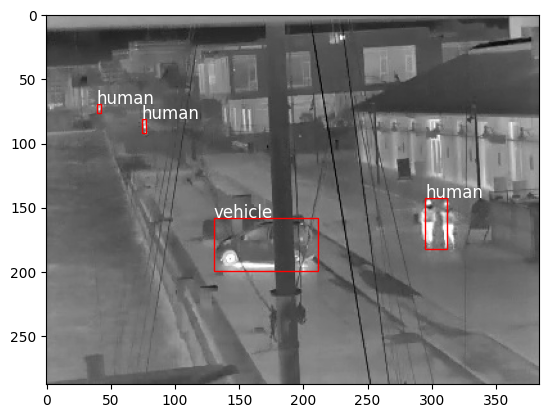

In [19]:
model.to(torch.device('cpu'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)#Batch size = 1
frame, _ = next(iter(test_dataloader))#We don't need the true targets
img = frame[0].numpy().transpose(1, 2 , 0)

with torch.no_grad():
    prediction = model(frame)

boxes = prediction[0]['boxes'].numpy()
labels = prediction[0]['labels'].numpy()
scores = prediction[0]['scores'].numpy()
labels = le.inverse_transform(labels)


for box, label, score in zip(boxes, labels, scores):
    if score > 0.7:
        x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        label = label
        plt.imshow(img)
        plt.text(x1, y1, label, fontsize = 12, c='white')
        plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
    
plt.show()

Extracting visual results on video clips

In [39]:
video_path = 'data/full/clips/20200514/clip_10_1744.mp4'
frames_list = []
size = (384, 288)
model.to(device)
cap = cv.VideoCapture(video_path)
output_path = 'outputs/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
counter = 0
while(True):
    ret, frame = cap.read()
    if (ret == True):
        # if counter%25 == 0:
        tens_frame = (frame/255).transpose((2, 0, 1))
        tens_frame = torch.tensor(tens_frame).type(torch.float).unsqueeze(0)
        tens_frame = tens_frame.to(device)
        with torch.no_grad():
            prediction = model(tens_frame)

        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = le.inverse_transform(labels)

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.7:
                x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

                cv.putText(frame,label,(x1,y1-4),cv.FONT_HERSHEY_SIMPLEX,0.4,(0,255,0),1,cv.LINE_AA)
                cv.rectangle(frame,(x1, y1),(x2, y2),(255,0,0),1)
        
        frames_list.append(frame)
        # cv.imshow('video', frame)
        # # counter += 1
        # if cv.waitKey(4) & 0xFF == ord('q'):
        #     cv.destroyAllWindows()
        #     break
            
        # else:
            # counter += 1
        
    else: 
        cv.destroyAllWindows()
        break

out = cv.VideoWriter('project.avi',cv.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frames_list)):
    out.write(frames_list[i])
out.release()

Plotting the train vs validation loss curves from file

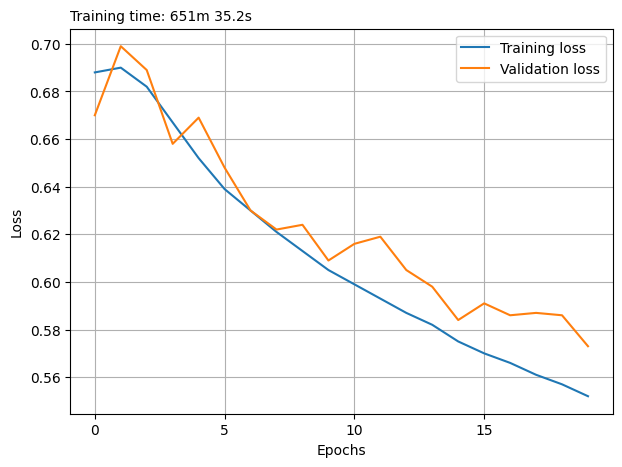

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
fig, axes = plt.subplots(figsize = (7,5))
losses = pd.read_csv('losses.csv', header=None, sep=' ', names=['Training loss', 'Validation loss'])
losses.plot(xlabel='Epochs',
    xticks=range(0, 20, 5),
    ylabel='Loss',
    grid=True,
    ax=axes)
axes.set_title('Training time: 651m 35.2s', loc='left', size = 10)
plt.show()